# ISIS and Al-Qaeda Analysis

This project intends to analyze internal ISIS and Al-Qaeda documents to see the similarities and differences in the reactions to world events between these groups. 

## Research Question:
How do ISIS and Al-Qaeda talk about each other and what do the organizational relationships of these organizations reveal about them? 

## Libraries

In [1]:
import glob
import pdfscraper
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
import sqlite3
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
import spacy
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image

## Pragmas

In [2]:
%matplotlib inline

## Configuration (and F0)

#### Ingestion, Cleaning and Structuring

Below, the pdf files originating from Al-Qaeda and ISIS are read in. The regex patterns are created, initial stopwords are established and we load in spacy's language module.

In [3]:
BASEPATH = "/Users/tylermanderfield/Desktop/DS5559_Project/"
# isis_docs = glob.glob("/Users/tylermanderfield/Desktop/DS5559_Project/Docs to use/*.pdf")
isis_docs = glob.glob(BASEPATH + "Docs to use/*.pdf")
# aq_docs = glob.glob("/Users/tylermanderfield/Desktop/DS5559_Project/UBL/*.pdf")
aq_docs = glob.glob(BASEPATH +"UBL/*.pdf")
para_pat = r'\n?[\W]\n\n+'
sent_pat =  r'([.;?!"“”]+)'
token_pat = r'([\W_]+)'
db_file = 'terrorist_groups.db'
print(len(isis_docs))
print(len(aq_docs))

nlp = spacy.load("en_core_web_sm")

extra_stopwords = """
us rest went least would much must long one like much say well without though yet might still upon
done every rather particular made many previous always never thy thou go first oh thee ere ye came
almost could may sometimes seem called among another also however nevertheless even way one two three
ever put would could should said still
""".strip().split()


143
250


#### MALLET Topic Modeling Preferences

In [4]:
max_words = 10000
mallet_path = '/Users/tylermanderfield/⁨Desktop⁩/DS5559_Project⁩/mallet-2.0.8/bin/mallet'
num_topics = 20
num_iters = 5000
show_interval = 100

# PREPARING THE DATA FOR ANALYSIS (F1-F3)

### Organizational Structure Initialization (Ordered Hierarchy of Content Objects)

In [5]:
OHCO = ['Org','doc_name', 'para_num', 'sent_num', 'token_num']
PARAS = OHCO[:3]
SENTS = OHCO[:4]

### Importing Documents and Extracting Text

In [6]:
codes_isis = [[f.replace('.pdf','').split('/')[-1],"ISIS"] for f in isis_docs]
codes_aq = [[f.replace('.pdf','').split('/')[-1],"AQ"] for f in aq_docs]

IS_df = pd.DataFrame(codes_isis, columns = ['doc_name','Org'])
AQ_df = pd.DataFrame(codes_aq, columns = ['doc_name','Org'])
frames = [IS_df, AQ_df]
T = pd.concat(frames)
files = isis_docs + aq_docs

T['text'] = [pdfscraper.extract_text(f) for f in files]
T = T.set_index(['Org','doc_name'])
T.head()
# for i in isis_docs:
#     extract_text(i)

# for doc in aq_docs:

text
Org  doc_name                                                                                             
ISIS Letter-from-Bin-Laden-Translation                   Document Title: Letters From Bin Laden  \nID: ...
     Pledges-and-Homages-Translation                      \nFrom Al-Jihad Group Publications \n \n\n \n...
     NMEC-2007-634187-Trans                              NMEC-2007-634187 \nFull Translation \n \nBroth...
     Attack-Explanation-Letter-to-a-Sheik-Translation    100607 3-82 TXFR 10-12 Sheikh Ltr \n \n\nIn Th...
     The-Muslims-in-Central-Asia-and-the-Upcoming-Ba...   \n\nPAGE 1 \n\nIn the name of Allah the merci...

### Organize by Paragraph

In [7]:
paras = T.text.str.split(para_pat, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = PARAS
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]
paras.head(10)

para_str
Org  doc_name                          para_num                                                   
ISIS Letter-from-Bin-Laden-Translation 0         Document Title: Letters From Bin Laden ID: AFG...
                                       1         Statement 7 (sic), pp. 001-003: Our invitation...
                                       2         To: King Fahd Bin ‘Abd-al ‘Aziz Al-Saud and th...
                                       3                                02-11-1414 (12 April 1994)
                                       4         King Fahd has asked Osama Bin Laden to return ...
                                       5         Statement 3, p. 007: Saudi Arabia Supports the...
                                       6                                 27-12-1414 (07 June 1994)
                                       7         The Yemeni communists have enslaved the Yemeni...
                                       8         Muslims now realize that the U.N. is an instru...
                                       9         Statement 4, pp. 009-010: The Banishment of Co...

### Organize by Sentence

In [8]:
sents = paras.para_str\
    .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = SENTS
del(paras)
sents.head(10)

sent_str
Org  doc_name                          para_num sent_num                                                   
ISIS Letter-from-Bin-Laden-Translation 0        0         Document Title: Letters From Bin Laden ID: AFG...
                                                1         The primary theme is the illegitimacy of the S...
                                                2         Each letter addresses a current event, describ...
                                                3         Most statements end with a call to action on t...
                                                4         The statements are coherently written and well...
                                                5         Bin Laden’s writing demonstrates an ability to...
                                       1        0                                    Statement 7 (sic), pp.
                                                1         001-003: Our invitation to Give Advice and Reform
                                       2        0         To: King Fahd Bin ‘Abd-al ‘Aziz Al-Saud and th...
                                       3        0                                02-11-1414 (12 April 1994)

### Organize by Token

In [9]:
tokenizer = RegexpTokenizer('\s+', gaps=True)

tokens = sents.sent_str\
    .apply(lambda x: pd.Series(nltk.pos_tag(tokenizer.tokenize(x))))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'pos_tuple'})

tokens.index.names = OHCO
tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
tokens = tokens.drop('pos_tuple', 1)

del(sents)
tokens.head(10)

pos  \
Org  doc_name                          para_num sent_num token_num        
ISIS Letter-from-Bin-Laden-Translation 0        0        0          NNP   
                                                         1          NNP   
                                                         2          NNP   
                                                         3          NNP   
                                                         4          NNP   
                                                         5          NNP   
                                                         6          NNP   
                                                         7          NNP   
                                                         8          NNP   
                                                         9           CD   

                                                                           token_str  
Org  doc_name                          para_num sent_num token_num                    
ISIS Letter-from-Bin-Laden-Translation 0        0        0                  Document  
                                                         1                    Title:  
                                                         2                   Letters  
                                                         3                      From  
                                                         4                       Bin  
                                                         5                     Laden  
                                                         6                       ID:  
                                                         7          AFGP-2002-003345  
                                                         8                     Date:  
                                                         9                        12

### Build Out Token Table

In [10]:
tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
tokens.head(10)

pos  \
Org  doc_name                          para_num sent_num token_num        
ISIS Letter-from-Bin-Laden-Translation 0        0        0          NNP   
                                                         1          NNP   
                                                         2          NNP   
                                                         3          NNP   
                                                         4          NNP   
                                                         5          NNP   
                                                         6          NNP   
                                                         7          NNP   
                                                         8          NNP   
                                                         9           CD   

                                                                           token_str  \
Org  doc_name                          para_num sent_num token_num                     
ISIS Letter-from-Bin-Laden-Translation 0        0        0                  Document   
                                                         1                    Title:   
                                                         2                   Letters   
                                                         3                      From   
                                                         4                       Bin   
                                                         5                     Laden   
                                                         6                       ID:   
                                                         7          AFGP-2002-003345   
                                                         8                     Date:   
                                                         9                        12   

                                                                    punc  num  
Org  doc_name                          para_num sent_num token_num             
ISIS Letter-from-Bin-Laden-Translation 0        0        0             0    0  
                                                         1             0    0  
                                                         2             0    0  
                                                         3             0    0  
                                                         4             0    0  
                                                         5             0    0  
                                                         6             0    0  
                                                         7             0    1  
                                                         8             0    0  
                                                         9             0    1

### Clean up Tokens table and Create Vocab Table

In [11]:
WORDS = (tokens.punc == 0)  & (tokens.num == 0)
tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
    .str.replace(token_pat, '')
#     .str.replace(r'["_*.\']', '')
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index(drop=True)
vocab.index.name = 'term_id'


/Users/tylermanderfield/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Build Out Vocab Table

In [12]:
# add proportion
vocab['p'] = vocab.n / vocab.n.sum()

# add Porter stem
stemmer = nltk.stem.porter.PorterStemmer()
vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))

# add in extrastop words and create stop word indicator column
extra_stopwords = ['unclassifiedfor','unclassified']
stopwords = set(nltk.corpus.stopwords.words('english') + extra_stopwords)
sw = pd.DataFrame({'x':1}, index=stopwords)
vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
del(sw)

In [13]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
    .set_index('term_str').term_id).fillna(-1).astype('int')

### Export Updated Vocab, Doc, and Tokens Tables

In [14]:
with sqlite3.connect(db_file) as db:
    T.to_sql('doc', db, if_exists='replace', index=True)
    tokens.to_sql('token', db, if_exists='replace', index=True)
    vocab.to_sql('vocab', db, if_exists='replace', index=True)

# Emotion Analysis

In [ ]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [ ]:
emo_cols = combo.columns

In [ ]:
tokens2 = tokens.join(combo, on='term_str', how='left')
tokens2[emo_cols] = tokens2[emo_cols].fillna(0)
tokens2.head(10)

In [ ]:
by_para = tokens2.groupby(PARAS)[emo_cols].sum()

In [ ]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

In [ ]:
by_para[emo].plot(**FIG, xticks=xticks)

In [ ]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)
by_sent[emo].plot(**FIG, xticks=xticks)

In [ ]:
EOM = tokens[emo_cols].reset_index(drop=True)
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

# Prepare Vector Space Model (F4)

In [15]:
db_name = 'terror_vs.db'


OHCO = ['Org','doc_name', 'para_num', 'sent_num', 'token_num']
ORGS = OHCO[:1]
DOCS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

BAG = DOCS
with sqlite3.connect(db_file) as db:
    tokens = pd.read_sql('SELECT * FROM token', db, index_col=OHCO)
    vocab = pd.read_sql('SELECT * FROM vocab', db, index_col='term_id')
    docs =  pd.read_sql('SELECT * FROM doc', db, index_col=DOCS)

In [16]:
WORDS = (tokens.punc == 0) & (tokens.num == 0)
BOW = tokens[WORDS].groupby(BAG + ['term_id'])['term_id'].count()
DTM = BOW.unstack().fillna(0)
bags = pd.DataFrame(index = DTM.index)
DTM = DTM.reset_index(drop=True)
DTM.index.name = 'bag_id'

### Compute TF-IDF

In [17]:
N_docs = DTM.shape[0]
vocab['df'] = DTM[DTM > 0].count()
vocab['idf'] = np.log10(N_docs / vocab.df)

###### Check the vocab table

In [18]:
vocab[vocab.stop==0].sort_values('n', ascending=False).head(500)\
    .sort_values('idf', ascending=False).head(10)

term_str    n         p   port_stem  stop  df       idf
term_id                                                           
12196        homage  252  0.000221       homag     0   1  2.592177
25072         ulama  207  0.000182       ulama     0   3  2.115056
6673          corps  246  0.000216        corp     0  11  1.550784
14294         khost  276  0.000242       khost     0  13  1.478233
1012        airport  458  0.000402     airport     0  14  1.446049
3387           asia  221  0.000194        asia     0  19  1.313423
18484        planes  215  0.000189       plane     0  20  1.291147
16375      mountain  443  0.000389    mountain     0  23  1.230449
16501    mujahideen  610  0.000536  mujahideen     0  25  1.194237
5425        central  279  0.000245     central     0  27  1.160813

### Generate TFIDF Metrics for Vocab Table

In [19]:
TFIDF = DTM * vocab['idf']
vocab['tfidf_sum'] = TFIDF.sum()
vocab['tfidf_mean'] = TFIDF.mean()
vocab['tfidf_max'] = TFIDF.max()

### Filter out additional stop words

In [20]:
additional_stopwords = ['make','sure','came','back','keep','mind','take','care','order','avoid','possible','aware','going','used','use','',"section","etc",'b','c','one','like','first','second','third','two','even','time','among','directorate','headquarter','day','without','whose','ask','also','upon','may','us','name','god','willing','took', 'place','peace','would','almighty','page','ask','may','mercy','though','brother','place','took','merciful','full','translation','praise','blessings','thanks','gracious','knows','dear','prayers','ask','let','gods','long','pray','though','taking','took','therefore','official','spokesman','blank','document','bless','soul','']
minus_apostrophe = [i.replace("'","") for i in nltk.corpus.stopwords.words('english')]
stopwords = set(nltk.corpus.stopwords.words('english') 
                + minus_apostrophe 
                + extra_stopwords 
                + additional_stopwords 
                + list(vocab[TFIDF.sum() == 0]))
sw = pd.DataFrame({'x':1}, index=stopwords)
vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
vocab[vocab.stop==0].sort_values('n', ascending=False).head(500)\
    .sort_values('idf', ascending=False).head(10)
# del(sw)

term_str    n         p  port_stem  stop  df       idf   tfidf_sum  \
term_id                                                                        
12196       homage  252  0.000221      homag     0   1  2.592177  653.228543   
24528      torghar  193  0.000170    torghar     0   2  2.291147  442.191325   
25072        ulama  207  0.000182      ulama     0   3  2.115056  437.816489   
16334       moslem  200  0.000176     moslem     0   8  1.689087  337.817354   
6673         corps  246  0.000216       corp     0  11  1.550784  381.492882   
14294        khost  276  0.000242      khost     0  13  1.478233  407.992420   
1012       airport  458  0.000402    airport     0  14  1.446049  662.290315   
6058     communist  189  0.000166  communist     0  17  1.361728  257.366561   
3387          asia  221  0.000194       asia     0  19  1.313423  290.266518   
18484       planes  215  0.000189      plane     0  20  1.291147  277.596554   

         tfidf_mean   tfidf_max  
term_id                          
12196      1.670661  653.228543  
24528      1.130924  435.317885  
25072      1.119735  219.965772  
16334      0.863983  231.404888  
6673       0.975685  176.789384  
14294      1.043459  239.473812  
1012       1.693837  423.692275  
6058       0.658226   51.745658  
3387       0.742370   77.491966  
18484      0.709966  207.874629

In [21]:
vocab[vocab.stop==0].sort_values('n', ascending=False).head(500)\
    .sort_values('idf', ascending=True).head(10)

term_str     n         p port_stem  stop   df       idf   tfidf_sum  \
term_id                                                                        
4943     brothers  2032  0.001785   brother     0  264  0.170573  346.603992   
18150      people  3099  0.002722     peopl     0  254  0.187343  580.576083   
11209        good  1153  0.001013      good     0  242  0.208361  240.240684   
26204        well   936  0.000822      well     0  217  0.255717  239.351134   
13595     islamic  1898  0.001667     islam     0  215  0.259738  492.983289   
14431        know  1016  0.000892      know     0  211  0.267894  272.180611   
21173        said  2625  0.002305      said     0  207  0.276206  725.041831   
1845        allah  2352  0.002066     allah     0  199  0.293324  689.897298   
16453    muhammad   746  0.000655  muhammad     0  198  0.295512  220.451629   
247           abu  1696  0.001490       abu     0  196  0.299921  508.665484   

         tfidf_mean  tfidf_max  
term_id                         
4943       0.886455  14.669263  
18150      1.484849  38.967352  
11209      0.614426  16.668911  
26204      0.612151  17.900192  
13595      1.260827  43.636034  
14431      0.696114  16.341552  
21173      1.854327  88.386052  
1845       1.764443  49.278378  
16453      0.563815   8.569835  
247        1.300935  77.679458

### Prepare a smaller set of tokens based on TFIDF for Vector Space Model

In [22]:
def get_top_terms(vocab, no_stops=True, sort_col='n', k=1000):
    if no_stops:
        V = vocab[vocab.stop == 0]
    else:
        V = vocab
    return V.sort_values(sort_col, ascending=False).head(k)

In [23]:
top_n = 5000
# TOPV = get_top_terms(vocab, sort_col='n')
TOPV = get_top_terms(vocab, sort_col='n', k = top_n)
tfidf_small = TFIDF[TOPV.index].stack().to_frame().rename(columns={0:'w'})
tfidf_small.head(10)

w
bag_id term_id          
0      18150    0.000000
       21173    0.000000
       1845     0.000000
       13878    0.315715
       4943     0.511718
       13595    0.000000
       247      0.299921
       16615    0.000000
       850      0.000000
       16507    0.000000

### Export VSM prepared data

In [24]:
with sqlite3.connect(db_name) as db:
    vocab.to_sql('vocab', db, if_exists='replace', index=True)
    tokens.to_sql('token', db, if_exists='replace', index=True)
    docs.to_sql('doc', db, if_exists='replace', index=True)
    tfidf_small.to_sql('tfidf_small', db, if_exists='replace', index=True)
    bags.reset_index().to_sql('bag', db, if_exists='replace', index=True, index_label='bag_id')

# HIERARCHICAL CLUSTERING (Tolu, Matthew, Tyler)

### Preparation for Hierarchical Clustering

In [25]:
with sqlite3.connect(db_name) as db:
    bags = pd.read_sql("SELECT * FROM bag", db, index_col='bag_id')
    tfidf = pd.read_sql("SELECT * FROM tfidf_small", db, index_col=['bag_id','term_id'])
TFIDF = tfidf.unstack()
TFIDF.columns = TFIDF.columns.droplevel(0)

In [26]:
labels = bags.apply(lambda x: ' '.join(x.astype('str')), 1).tolist()

In [27]:
vocab.head()

term_str      n             p port_stem  stop   df       idf  \
term_id                                                                
0              a  15783  1.386171e-02         a     1  370  0.023975   
1             aa      4  3.513074e-06        aa     0    3  2.115056   
2           aaan      1  8.782685e-07      aaan     0    1  2.592177   
3           aadm      1  8.782685e-07      aadm     0    1  2.592177   
4        aaeesah      1  8.782685e-07   aaeesah     0    1  2.592177   

          tfidf_sum  tfidf_mean  tfidf_max  
term_id                                     
0        378.397951    0.967770  25.509435  
1          8.460222    0.021637   4.230111  
2          2.592177    0.006630   2.592177  
3          2.592177    0.006630   2.592177  
4          2.592177    0.006630   2.592177

###### Cleaning so that we make sure there are no duplicated documents causing errors

In [28]:
TFIDF_clean = TFIDF.drop_duplicates()
print(len(TFIDF_clean))
print(len(TFIDF))
TFIDF.tail()

383
391


term_id  7         20     27        28     29     41        53     57     \
bag_id                                                                     
386        0.0  0.000000    0.0  0.000000    0.0    0.0  0.000000    0.0   
387        0.0  1.689087    0.0  0.000000    0.0    0.0  0.836302    0.0   
388        0.0  0.000000    0.0  0.000000    0.0    0.0  0.000000    0.0   
389        0.0  0.000000    0.0  0.000000    0.0    0.0  0.000000    0.0   
390        0.0  0.000000    0.0  1.194237    0.0    0.0  0.000000    0.0   

term_id  61        80     ...  26723       26740      26744  26796     26808  \
bag_id                    ...                                                  
386        0.0  0.000000  ...    0.0    0.000000   0.000000    0.0  0.000000   
387        0.0  0.000000  ...    0.0    0.000000   0.000000    0.0  0.000000   
388        0.0  0.000000  ...    0.0  220.335024  67.396596    0.0  0.000000   
389        0.0  0.558753  ...    0.0    0.000000   0.000000    0.0  1.388057   
390        0.0  0.000000  ...    0.0    0.000000   0.000000    0.0  0.000000   

term_id  26818      26819  26837     26850  26871  
bag_id                                             
386        0.0   0.000000    0.0  0.000000    0.0  
387        0.0   0.000000    0.0  0.000000    0.0  
388        0.0   0.000000    0.0  8.189671    0.0  
389        0.0   0.000000    0.0  0.000000    0.0  
390        0.0  35.822102    0.0  0.000000    0.0  

[5 rows x 5000 columns]

### Calculate Cosine Similarity Between Documents

In [29]:
SIMS = pdist(TFIDF_clean, metric='cosine')

###### Give any document with similarity that causes an error a value of 1, preventing error in linkage method

In [30]:
SIMS[np.isnan(SIMS)] = 1

#### Actually conduct clustering

In [31]:
TREE = sch.linkage(SIMS, method='ward')

In [32]:
cluster_nums = sch.fcluster(TREE, t=1.9, criterion='distance')

#### Dendrogram of document clustering

In [33]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, 100))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=10)

As can be seen below the documents fall into 5 clusters. Four of these clusters appear to be relative homogenous in terms of the group that wrote them, though the final cluster (light blue) seems to have quite a mix. This provides us with a good idea of groupings of topics on subject matter, however, it doesn't provide us much information about the content of these clusters themselves. To dive a level deeper on this idea, we grouped the documents based on their cluster and ran topic modelling on each of the 5 clusters. The idea here is that we will be able to understand which topics are most prominent in a given cluster and we will then be able to compare and contrast these topics to determine what makes each cluster unique. 

<Figure size 432x288 with 0 Axes>

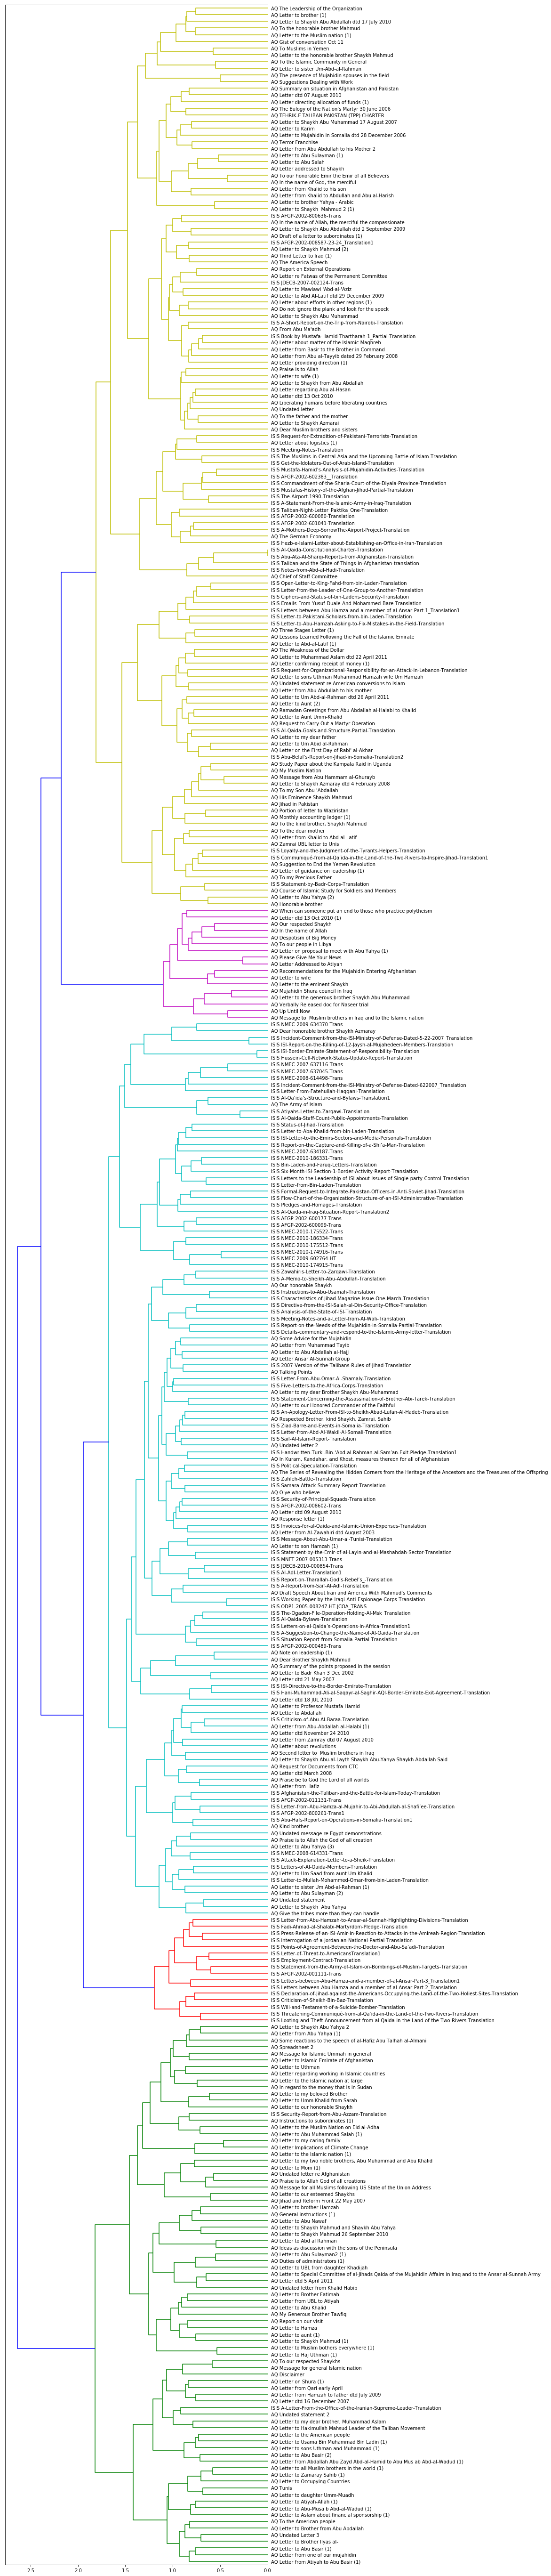

In [34]:
plot_tree(TREE, labels)

#### Assign Cluster to Documents

In [35]:
clusters = TFIDF_clean.index.to_frame()

In [36]:
clusters['bag_id'] = cluster_nums
clusters.rename(columns = {"bag_id":"cluster"}, inplace = True)

##### Gather names of documents in each cluster for Topic Modeling

In [37]:
clust_1 = list(bags.doc_name.loc[list(clusters[clusters["cluster"]==1].index)])
clust_2 = list(bags.doc_name.loc[list(clusters[clusters["cluster"]==2].index)])
clust_3 = list(bags.doc_name.loc[list(clusters[clusters["cluster"]==3].index)])
clust_4 = list(bags.doc_name.loc[list(clusters[clusters["cluster"]==4].index)])
clust_5 = list(bags.doc_name.loc[list(clusters[clusters["cluster"]==5].index)])

# MALLET TOPIC MODELING (Tolu, Matthew, Tyler)

To get a sense of what topics may be salient for the entire document, we used MALLET topic modelling to determine 20 topics.

### Preparation

##### Cleaning to remove # and punc. just to be sure and restructuring for Mallet

In [38]:
### SEQUEL QUERY PULL IN HERE!!!!
sql = """
SELECT * FROM token 
WHERE term_id IN (
    SELECT term_id FROM vocab 
    WHERE stop = 0 
    AND term_str NOT IN ('said','tn','translated','say','many','still','way','see','saw','know','became','great','told','good')
    ORDER BY tfidf_sum DESC LIMIT {}
)
-- AND (author = 'poe' OR author = 'austen') 
AND (pos NOT LIKE 'NNP%')
""".format(max_words)
corpus_db = 'terror_vs.db'
with sqlite3.connect(corpus_db) as db:
    tokens = pd.read_sql(sql, db)

tokens_nonum = tokens.loc[tokens.num == 0]
tokens_clean = tokens_nonum.loc[tokens_nonum.punc == 0]

tokens_clean.head()


Org                           doc_name  para_num  sent_num  token_num  \
0  ISIS  Letter-from-Bin-Laden-Translation         0         0         18   
1  ISIS  Letter-from-Bin-Laden-Translation         0         0         19   
2  ISIS  Letter-from-Bin-Laden-Translation         0         0         21   
3  ISIS  Letter-from-Bin-Laden-Translation         0         0         27   
4  ISIS  Letter-from-Bin-Laden-Translation         0         0         29   

   pos  token_str  punc  num   term_str  term_id  
0   JJ  following     0    0  following    10531  
1  NNS    letters     0    0    letters    14804  
2  VBN    written     0    0    written    26550  
3   VB      cover     0    0      cover     6803  
4   NN      range     0    0      range    19763

In [39]:
chaps = tokens_clean.groupby(['Org','doc_name']).apply(lambda x: " ".join(x.term_str)).to_frame().rename(columns={0:'term_str'})
corpus = chaps
corpus = corpus.reset_index()
corpus = corpus.rename(columns={'Org':'doc_label', 'doc_name':'doc_title','term_str':'doc_content'})
corpus.head()

doc_label                                          doc_title  \
0        AQ                                         06 Ramadan   
1        AQ             A Letter to the Sunnah people in Syria   
2        AQ                           AQ Accounting Ledger (1)   
3        AQ  Addendum to the report of the Islamic Maghreb (2)   
4        AQ                    Administrative instructions (1)   

                                         doc_content  
0  fully original handwritten appears torn notebo...  
1  series uncover road criminals letter people in...  
2  monthly current balance forwarded previous mon...  
3  report situation following unity unity brother...  
4  administrative instructions administrator must...

In [40]:
corpus.index.rename('doc_key', inplace=True)
corpus.head()

doc_label                                          doc_title  \
doc_key                                                                
0              AQ                                         06 Ramadan   
1              AQ             A Letter to the Sunnah people in Syria   
2              AQ                           AQ Accounting Ledger (1)   
3              AQ  Addendum to the report of the Islamic Maghreb (2)   
4              AQ                    Administrative instructions (1)   

                                               doc_content  
doc_key                                                     
0        fully original handwritten appears torn notebo...  
1        series uncover road criminals letter people in...  
2        monthly current balance forwarded previous mon...  
3        report situation following unity unity brother...  
4        administrative instructions administrator must...

In [41]:
corpus.to_csv('terrorists.csv', index=True)
!{mallet_path} import-file --input terrorists.csv --output terrorists.mallet --keep-sequence TRUE
!{mallet_path} train-topics --input terrorists.mallet --num-topics {num_topics} --num-iterations {num_iters} \
--output-doc-topics terrorists-doc-topics.txt \
--output-topic-keys terrorists-topic-keys.txt \
--word-topic-counts-file terrorists-word-topic-counts-file.txt \
--topic-word-weights-file terrorists-topic-word-weights-file.txt \
--xml-topic-report terrorists-topic-report.xml \
--xml-topic-phrase-report terrorists-topic-phrase-report.xml \
--show-topics-interval {show_interval} \
--use-symmetric-alpha false  \
--optimize-interval 100 \
--diagnostics-file terrorists-diagnostics.xml

/bin/sh: /Users/tylermanderfield/⁨Desktop⁩/DS5559_Project⁩/mallet-2.0.8/bin/mallet: No such file or directory
/bin/sh: /Users/tylermanderfield/⁨Desktop⁩/DS5559_Project⁩/mallet-2.0.8/bin/mallet: No such file or directory


#### Analysis of the Corpus Topics 

The topics above surface some particularly interesting artifacts. For example, topic one appears to highlight larger scale discussions about nations, leaders and countries. Topic 9 seems to be highlighting letters discussing attacks on airports, as we see the metnion of planes, airports, launchers and rockets. Topic 10 draws out more about domestic life, including conversations about marriage and family. To highlight one final topic, topic 19 appears to talk more about organizational procedures and more formal groups, as words like "committee", "deputy", "organization", "president", and "council" appear here.

#### TOPIC MODELING F5: EXAMINE IN POLO:
There should be the topics for the initial model named terrorists
Then, there is additionally topic modeling done for each cluster determined above, where each is named: terrorists_clusterX. 

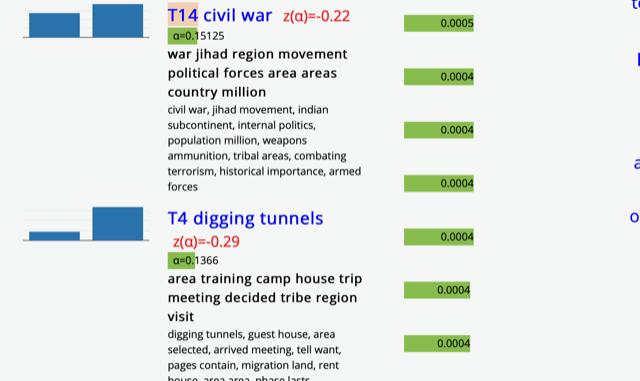

In [43]:
Image(filename= BASEPATH+"20_topics1.png", width = 600, height = 600)

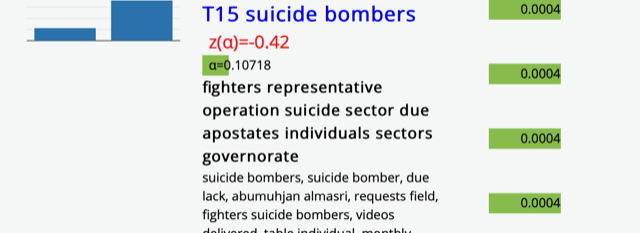

In [44]:
Image(filename= BASEPATH+"20_topics2.png", width = 600, height = 600)

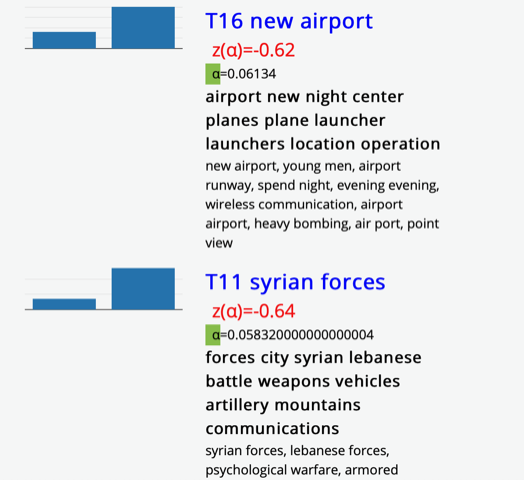

In [45]:
Image(filename= BASEPATH+"20_topics3.png", width = 600, height = 600)

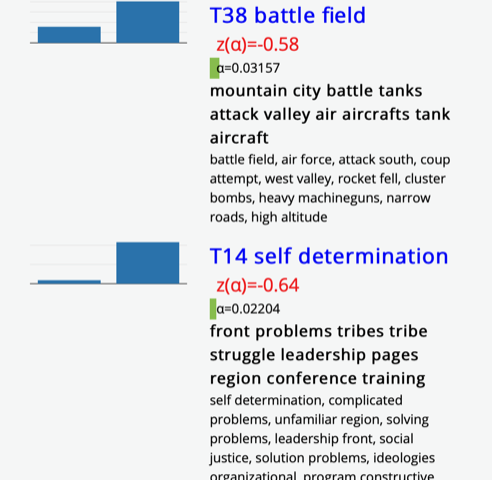

In [46]:
Image(filename= BASEPATH+"40topics_1.png", width = 600, height = 600)

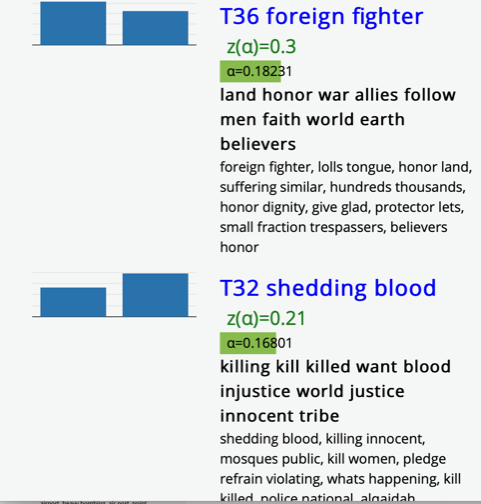

In [47]:
Image(filename= BASEPATH+"40topics_2.png", width = 600, height = 600)

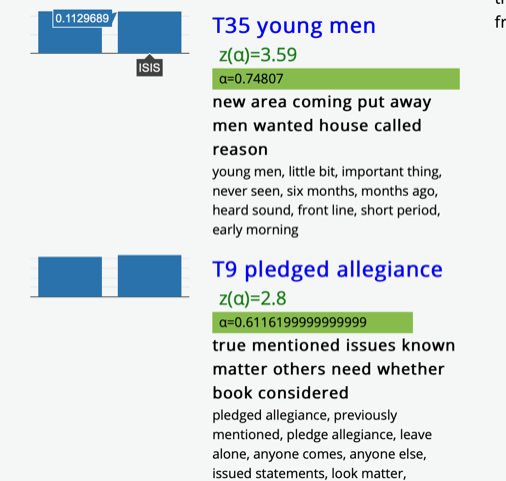

In [48]:
Image(filename= BASEPATH+"40topics_3.png", width = 600, height = 600)

# KDE Similarity Graph (F6)

### Methodology

To determine similarity between word pairs, we will utilize the methodology that McClure developed. While his methodology is more geared towards longer form text, such as novels, we thought it would be interesting to see the results of this method and see which words appear more similar to each other. We used overlap of Kernel Density Estimates to establish a measure for coocurrence.

In [72]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .97
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000 #2000
kde_samples = 1000

In [73]:
from sklearn.neighbors import KernelDensity as KDE
from IPython.display import display, HTML

In [74]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [75]:
with sqlite3.connect(db_name) as db:
    V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0 and term_str not in ('asked','right','tc','said','page','good','made','well','however','though','knew','want','believe','things','go','given','went','three','two','known','still','become','every','know','many','way','put','asked','others','people','told','since','situation','best','better','come')", db, index_col='term_id')
    K = pd.read_sql("SELECT term_id, term_str FROM token WHERE term_id >= 0", db)

In [76]:
K.rename_axis('offset', inplace=True)
V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)] 

In [77]:
V1[V1.term_str == "taliban"]

term_str     n         p port_stem  stop  df       idf    tfidf_sum  \
term_id                                                                       
23864    taliban  1157  0.001016   taliban     0  46  0.929419  1075.337697   

         tfidf_mean   tfidf_max  
term_id                          
23864      2.750224  461.921206

In [78]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id          23864        16501       13878        850         1845   \
term_str       taliban   mujahideen       jihad  afghanistan       allah   
n                 1157          610        2295         1415        2352   
p           0.00101616  0.000535744  0.00201563   0.00124275  0.00206569   
port_stem      taliban   mujahideen       jihad  afghanistan       allah   
stop                 0            0           0            0           0   
df                  46           25         189          125         199   
idf           0.929419      1.19424    0.315715     0.495267    0.293324   
tfidf_sum      1075.34      728.484     724.566      700.802     689.897   
tfidf_mean     2.75022      1.86313     1.85311      1.79233     1.76444   
tfidf_max      461.921      218.545     80.1916      138.179     49.2784   

term_id           1012         12196       16507       16615        16375  
term_str        airport       homage   mujahidin     muslims     mountain  
n                   458          252        1322        1549          443  
p           0.000402247  0.000221324  0.00116107  0.00136044  0.000389073  
port_stem       airport        homag   mujahidin      muslim     mountain  
stop                  0            0           0           0            0  
df                   14            1         130         172           23  
idf             1.44605      2.59218    0.478233    0.356648      1.23045  
tfidf_sum        662.29      653.229     632.225     552.448      545.089  
tfidf_mean      1.69384      1.67066     1.61694     1.41291      1.39409  
tfidf_max       423.692      653.229      213.77     86.3089      275.621

In [79]:
TOP_TERMS = V1.sort_values(vocab_weight, ascending=False).term_str.head(20)
TOP_TERMS

term_id
23864        taliban
16501     mujahideen
13878          jihad
850      afghanistan
1845           allah
1012         airport
12196         homage
16507      mujahidin
16615        muslims
16375       mountain
11233     government
15959       military
10574         forces
26038            war
11388          group
247              abu
9157           enemy
4454             bin
13595        islamic
13589          islam
Name: term_str, dtype: object

In [80]:
K = K[K.term_id.isin(V1.index)]
K.head(11).T

offset      4      5     7          13     20       25     27      28     37  \
term_id   4454  14528  7195      10531   6803    20244  21381    3171  21381   
term_str   bin  laden  date  following  cover  related  saudi  arabia  saudi   

offset        38       47  
term_id    20162    26238  
term_str  regime  western

In [81]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame() # NOT WORKING BECAUSE OFFSET DISAPPEARS WHEN Transposing

In [82]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)
B.head()

offset  \
term_str                                                         
abd          [2312, 22227, 22294, 23426, 25726, 25737, 2578...   
abdallah     [15569, 15870, 15951, 15959, 15967, 15995, 160...   
abdalrahman  [9627, 54674, 91882, 91901, 96201, 97199, 9732...   
abdullah     [70993, 74240, 74491, 74667, 74859, 75047, 755...   
abi          [6148, 6166, 8653, 9158, 9170, 9178, 9415, 942...   

                                                             x  
term_str                                                        
abd          [[2312], [22227], [22294], [23426], [25726], [...  
abdallah     [[15569], [15870], [15951], [15959], [15967], ...  
abdalrahman  [[9627], [54674], [91882], [91901], [96201], [...  
abdullah     [[70993], [74240], [74491], [74667], [74859], ...  
abi          [[6148], [6166], [8653], [9158], [9170], [9178...

In [83]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
# B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)

In [84]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1) # scaling and converting to di

In [85]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])
pairs.head(10).T


0            1         2    3     4    5       6         7  \
x       abd          abd       abd  abd   abd  abd     abd       abd   
y  abdallah  abdalrahman  abdullah  abi  able  abu  accept  accepted   

           8       9  
x        abd     abd  
y  according  action

In [86]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)
pairs['overlap'] = pairs.apply(overlap, axis=1)
pairs.sort_values('overlap', ascending=False).head(10)

x          y   overlap
70066          bir   shilling  0.947328
235709    lebanese     zahleh  0.890373
237714  legalistic      ulama  0.873153
50779         asia    central  0.839635
287531     platoon   platoons  0.809392
228970     landing  launchers  0.793927
230921    launcher     runway  0.787697
235617    lebanese     syrian  0.784289
231263   launchers     planes  0.783137
23089    aircrafts     haqani  0.780590

In [87]:
pairs_alt = pairs[pairs.overlap > .68 ].query("x not in ['could','should','would','either','bring','due','cannot','instead','open','think','might','saw','seen','either', 'put','made','way','good','people','good','many','others','except','much','say','know','well','see','say'] & y not in ['could','should','would','either','bring','due','cannot','instead','open','think','might','saw','seen','either','put','made','way','good','people','good','many','others','except','much','say','know','well','see','say']").sort_values('overlap', ascending=False).sort_values('overlap', ascending=False)
pairs_alt = pairs_alt.rename(columns ={'Overlap':'Weight','x':'Source','y':'Target'})
pairs_alt.head()
print(len(pairs_alt))
pairs_alt.to_csv("coocurrence_graph.csv",index = False)

1108


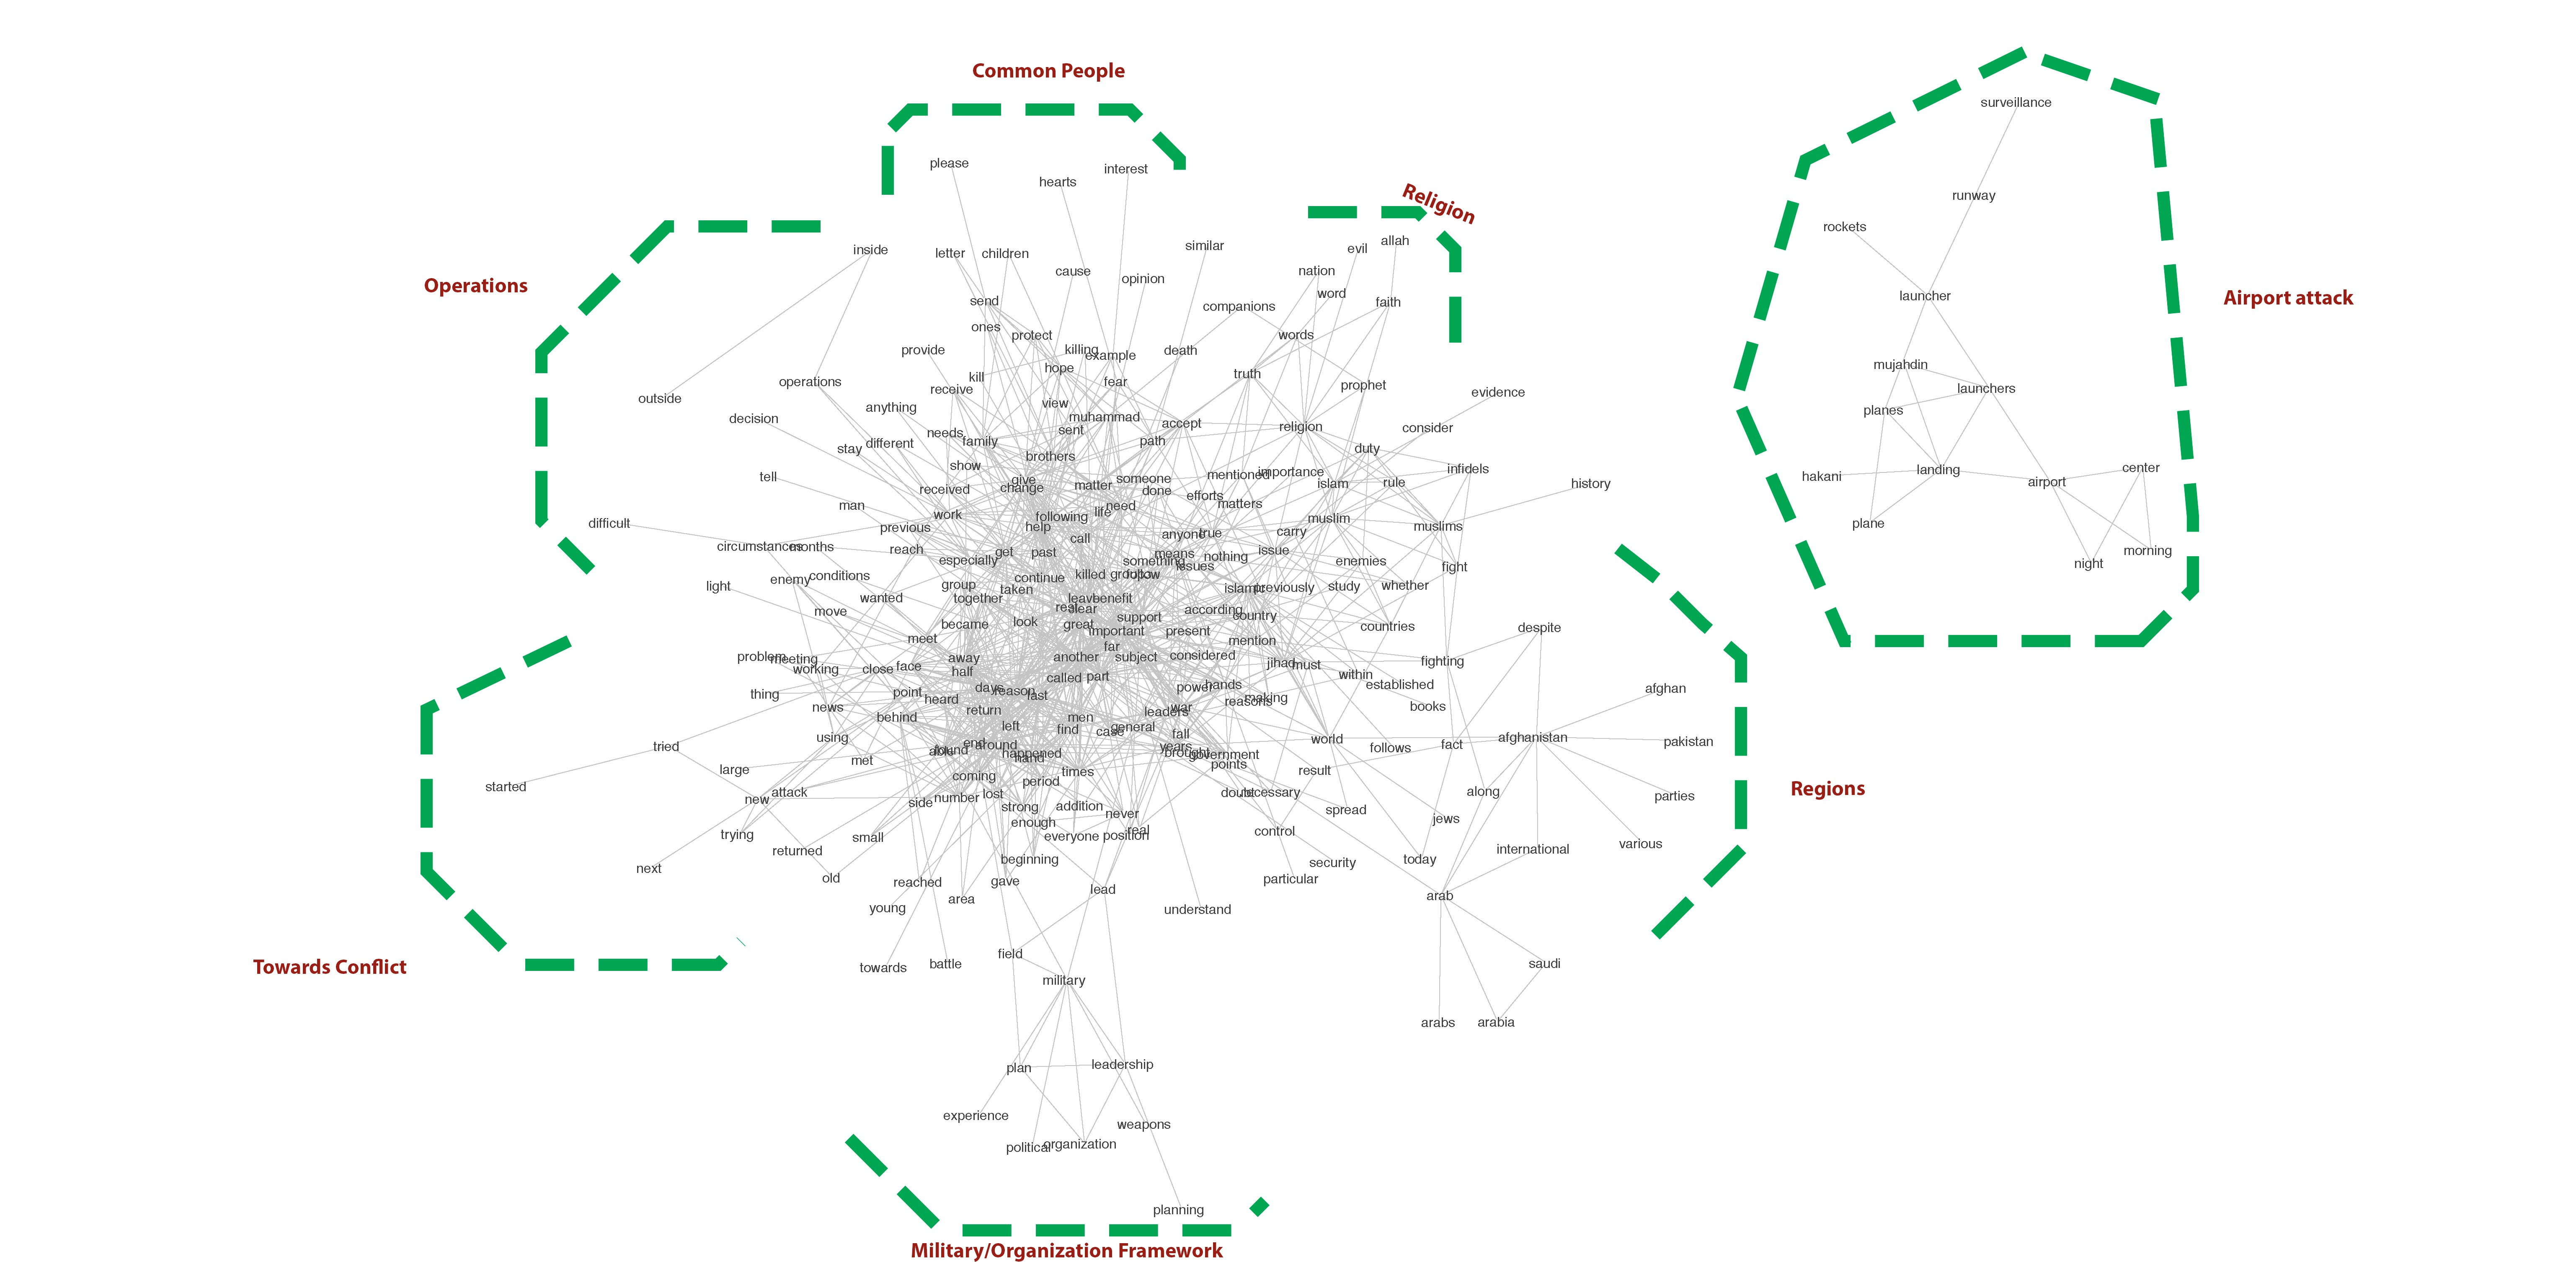

In [88]:
Image(filename= BASEPATH+"coocurrence_graph.jpeg", width = 1000, height = 1000)

# Radial Hierarchies of Organizations

This section creates similar plots the Organization Hierarchies that we created before. This time though, we focus on references to organizations, groups and geopolitical entities. To achieve this, we selected references to other group within a group's documents (i.e. references to Al-Qaeda from ISIS and vice versa) and references to the U.S. to conduct a comparison between Al-Qaeda and ISIS. 

The idea is to trace the other groups that are mentioned in paragraphs that refer to one of the two organizations/people of interest. We expect that Al-Qaeda will be more directly revealing of organizational connections to ISIS than ISIS itself. If ISIS mentions a group, we do not know if that group is actually related to ISIS or just referred to by ISIS in their own documents. However, if Al-Qaeda mentions ISIS and also mentions another group in the same paragraph, then it is more likely that a some kind of relationship is present.

For example, when Al-Qaeda mentions ISIS, we want to know what other groups they associate them with. So, we selected paragraphs in which ISIS was mentioned and found any other groups that were also mentioned in those paragraphs. This establishes a relatively "direct" relationship with them, and we plot these organizations at the second tier in the visual. Then, we identify the organizations that co-occur with these "directly" related organizations, but do not co-occur with ISIS, and plot those at the third tier. This establishes a relationship mapping between the organization and other groups. 

###### Split by paragraphs and separate out documents based on Organization

In [96]:
paras = T.text.str.split(para_pat, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = PARAS
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]
ISIS_paras = paras.loc['ISIS']
AQ_paras = paras.loc['AQ']

In [97]:
AQ_paras.head()

para_str
doc_name                           para_num                                                   
Letter to Shaykh from Abu Abdallah 0         (Fully Translated) In the Name of Allah, the M...
                                   1         Rahman pm (TN: sic; “pm” as given in Latin cha...
Dear Muslim brothers and sisters   1         Page 1 In the name of God, the Compassionate, ...
                                   4         good jihadi movement, we assure you that we ar...
                                   7         We remind our brethren, the Mujahidin, everywh...

###### Get the entities for each subsetted dataframe

In [98]:
AQ_paras['ents'] = AQ_paras.para_str.apply(lambda x: [(X.text, X.label_) for X in nlp(x).ents])
ISIS_paras['ents'] = ISIS_paras.para_str.apply(lambda x: [(X.text, X.label_) for X in nlp(x).ents])

#### References of AQ and US in ISIS Documents

In [111]:
ISIS_paras['ent_org'] = ISIS_paras.ents.apply(lambda x: [ent[0] for ent in x if ent[1] == 'ORG' or ent[1] == 'NORP' or ent[1] == 'GSP'])

ISIS_paras["has_aq"] = ISIS_paras.ent_org.apply(lambda x: "Al-Qaeda" in x or "Al Qaeda" in x or "Al Qaida" in x or "Al-Qaida" in x)
ISIS_paras["has_us"] = ISIS_paras.ent_org.apply(lambda x: "Americans" in x or "American" in x or "US" in x or "USA" in x or "United States" in x or "the United States of America" in x or "America" in x)

# collecting references to Al-Qaeda
ISIS_about_aq = ISIS_paras[ISIS_paras["has_aq"]] # paragraphs with AQ mentioned
# Finding other organizations mentioned in these paragraphs
aq_related_orgs = list(set([i for sublist in list(ISIS_about_aq.ent_org) for i in sublist if i not in ['AL QAIDA STAFF COUNT PUBLIC',"Al-Qaeda","Al Qaeda","Al-Qaida","Al Qaida","the Jihad Islamic","Shariea","SECRET",'Duties of','Muslim',"Muslims",'Islam',"Islamic",'OPSEC','Page 1 Al Qaida','Abu Mubtassem','Sayaf’s Arabs','Interaction with Jihad','Forbid','Single','Al Mujaheedeen','Arab','Mujaheedeen','Sheikh Albani','Jaysh Al Mujahedeen’s'] and "(" not in i and "-" not in i and "committee" not in i.lower() ]))
# Create direct graph edges between AQ and these organizations
secondary_related_aq = []
for m in aq_related_orgs:
    secondary_related_aq.append(("Al-Qaeda", m,1))

# Find organizations that are discussed in paragraphs with the AQ-connected organizations that we just found
# (This establishes an indirect connection to AQ and allows us to establish an inner and outer circle)
terciary_related_aq = []
for i in list(set(aq_related_orgs)):
    subset = ISIS_paras.ent_org.apply(lambda x: i in x)
    related_orgs = [j for sublist in list(ISIS_paras[subset].ent_org) for j in sublist if j not in [i, i.replace("-"," "),i.lower(),"Al-Qaeda","Al Qaeda","Al-Qaida","Al Qaida","Shariea","SECRET",'Duties of','Committee'] and "(" not in j and "-" not in j and "1" not in j and "2" not in j and "3" not in j and "4" not in j and "5" not in j and "6" not in j and "7" not in j and "8" not in j and "9" not in j and "0" not in j]
    for k in related_orgs:
        if k not in aq_related_orgs and 'Abdul Rasool Siyaf' not in k and "Mujahedeen" not in k and "FPS" not in k and "Sheik" not in k and k not in ["Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE","HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','AL Qaida','Defense','International Preparation','‘Umar Al Mukhtar','USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','AL QAEDA','Abdallah','Prophetic','AL QAIDA','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee']:
            terciary_related_aq.append((i, k,1))
    
    
# collecting refernces to the US
ISIS_about_us = ISIS_paras[ISIS_paras['has_us']]
us_related_orgs = list(set([i for sublist in list(ISIS_about_aq.ent_org) for i in sublist if i not in ["USA","the United States","Americans","American","America","US",'United States',"the United States of America","SECRET",'Duties of','Muslim',"Muslims",'Islam',"Islamic",'OPSEC','Page 1 Al Qaida','Abu Mubtassem','Sayaf’s Arabs','Interaction with Jihad','Forbid','Single','Al Mujaheedeen','Arab','Mujaheedeen','Sheikh Albani','Jaysh Al Mujahedeen’s',"Shariea","Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE","HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','Defense','International Preparation','‘Umar Al Mukhtar''USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','Abdallah','Prophetic','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee',"USA","the United States","Americans","America","US",'United States',"the United States of America"] and "(" not in i and "-" not in i and "committee" not in i.lower() ]))
# create edges between US and directly related organizations
secondary_related_us = []
for m in us_related_orgs:
    secondary_related_us.append(("US", m,1))
# Find entities that are mentioned in paragraphs with organizations that are directly mentioned with the US
# This establishes an indirect relationship to the US (through an organization that is directly related to the US)
terciary_related_us = []
for i in list(set(us_related_orgs)):
    subset = ISIS_paras.ent_org.apply(lambda x: i in x)
    related_orgs = [j for sublist in list(ISIS_paras[subset].ent_org) for j in sublist if j not in [i, i.replace("-"," "),i.lower(),'AL QAIDA STAFF COUNT PUBLIC','',"USA","the United States","Americans","America","US",'United States',"the United States of America","Shariea",'Shariea',"SECRET",'Duties of','Committee'] and "(" not in j and "-" not in j and "1" not in j and "2" not in j and "3" not in j and "4" not in j and "5" not in j and "6" not in j and "7" not in j and "8" not in j and "9" not in j and "0" not in j]
    for k in related_orgs:
        if k not in us_related_orgs and 'Abdul Rasool Siyaf' not in k and "Mujahedeen" not in k and "FPS" not in k and "Sheik" not in k and k not in ['Arabs’','Great','Jeep',"Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE",'Qur’ans','Their Position Regarding World Bodies','the Caucasus for sixty years','Shaykhs','Qibla','Ulama','Fanatic Devotion','Movement','Interpreters','ING','The Most Important Negative Attributes','','Qur’an','Quran','Arabic',"HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','Defense','International Preparation','‘Umar Al Mukhtar','USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','Abdallah','Prophetic','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee','Forbid',"USA","the United States","Americans","America","US",'United States',"the United States of America",'American']:
            terciary_related_us.append((i, k,1))

In [112]:
## EXPORT THESE GRAPHS AS CSV FOR Cytoscape and AS GEXF for GEPHI
print("AQ Inner Circle Size:",len(secondary_related_aq))
print("AQ Outer Circle Size:",len(terciary_related_aq))
isis_about_aq = list(set(secondary_related_aq + terciary_related_aq))
isis_ab_aq_df = pd.DataFrame(isis_about_aq,columns = ['Source','Target',"Weight"])
isis_ab_aq_df.to_csv("ISIS_about_AQ.csv",index = False)
NG = nx.Graph()
NG.add_weighted_edges_from(isis_about_aq)
nx.write_gexf(NG, "{}.gexf".format("ISIS_About_AQ_network"))

print("US Inner Circle Size:", len(secondary_related_us))
print("US Outer Circle Size:", len(terciary_related_us))
isis_about_us = list(set(secondary_related_us + terciary_related_us))
isis_ab_us_df = pd.DataFrame(isis_about_us,columns = ['Source','Target',"Weight"])
isis_ab_us_df.to_csv("ISIS_about_US.csv",index = False)
NG_u = nx.Graph()
NG_u.add_weighted_edges_from(isis_about_us)
nx.write_gexf(NG_u, "{}.gexf".format("ISIS_About_US_network"))

AQ Inner Circle Size: 36
AQ Outer Circle Size: 4787
US Inner Circle Size: 37
US Outer Circle Size: 3015


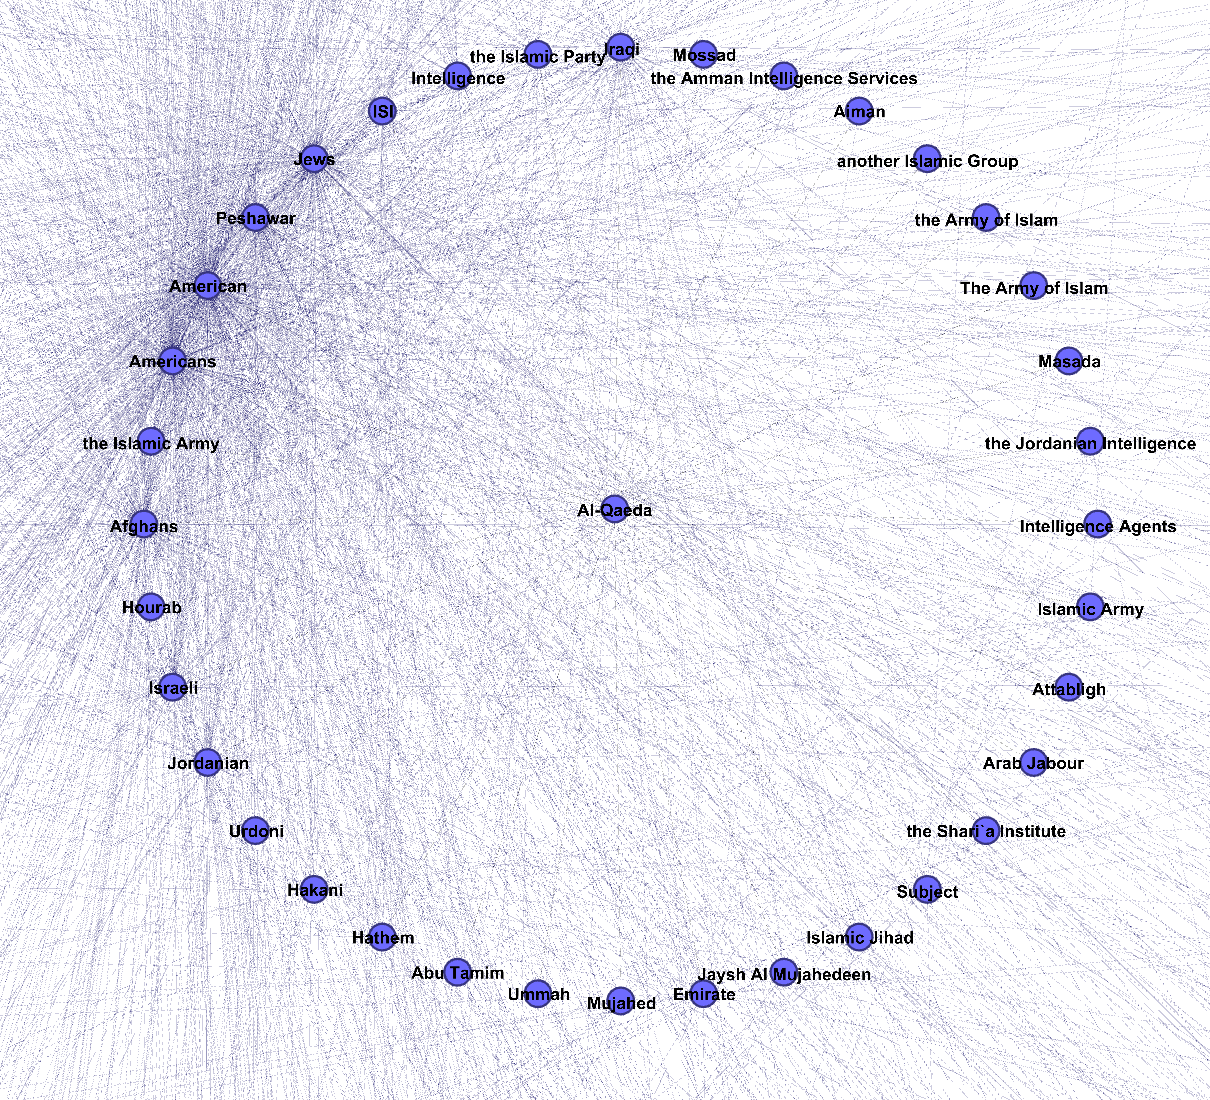

In [9]:
Image(filename= BASEPATH+"ISIS about AQ.png", width = 600, height = 600)

In [114]:
# amman intelligence service: Jordanian Intelligence...works closely with US intelligence service
#     AQ always suspicious of Jordanian intel.
    
# Jaysh Al Mujahedeen: ...AQ Affiliate
    
# ISI: Pakistani Intelligence...
    
# VERY VERY CONCERNED ABOUT INTELLIGENCE TRACKING

# Hakani: (haqqani) Trusted AQ ally, insurgent group that works with AQ and Taliban in Afghanistan
    
# Abu Tamim: appointed senior sharia official for Ansar al-Sharia (group responsible for Benghazi attack in Libya)
    
# Arab Jabour, Hourab, Al: Place in Iraq (neighbors Baghdad)

In [8]:
Image(filename= BASEPATH+"ISIS about US.png", width = 600, height = 600)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tylermanderfield/Desktop/DS5559_Project/ISIS about US.png'

In [116]:
# Similar to above...

### REFERENCES OF ISIS and US in AQ Documents

In [125]:
AQ_paras['ent_org'] = AQ_paras.ents.apply(lambda x: [ent[0] for ent in x if ent[1] == 'ORG' or ent[1] == 'NORP' or ent[1] == 'GSP'])

AQ_paras["has_isis"] = AQ_paras.ent_org.apply(lambda x: "ISIS" in x or "ISIL" in x or "Islamic State" in x or "Daesh" in x or "Islamic State" in x or x == "IS")
AQ_paras["has_us"] = AQ_paras.ent_org.apply(lambda x: "Americans" in x or "American" in x or "US" in x or "USA" in x or "United States" in x or "the United States of America" in x or "America" in x)

AQ_about_isis = AQ_paras[AQ_paras["has_isis"]]
AQ_about_us = AQ_paras[AQ_paras['has_us']]
isis_related_orgs = list(set([i for sublist in list(AQ_about_isis.ent_org) for i in sublist if i not in ["Shariea","SECRET",'Duties of','Muslim',"Muslims",'Islam',"Islamic",'OPSEC','Page 1 Al Qaida','Abu Mubtassem','Sayaf’s Arabs','Interaction with Jihad','Forbid','Single','Al Mujaheedeen','Arab','Mujaheedeen','Sheikh Albani','Jaysh Al Mujahedeen’s'] and "(" not in i and "-" not in i and "committee" not in i.lower() ]))
us_related_orgs = list(set([i for sublist in list(AQ_about_us.ent_org) for i in sublist if i not in ["USA","the United States","Americans","American","America","US",'United States',"the United States of America","SECRET",'Duties of','Muslim',"Muslims",'Islam',"Islamic",'OPSEC','Page 1 Al Qaida','Abu Mubtassem','Sayaf’s Arabs','Interaction with Jihad','Forbid','Single','Al Mujaheedeen','Arab','Mujaheedeen','Sheikh Albani','Jaysh Al Mujahedeen’s',"Shariea","Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE","HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','Defense','International Preparation','‘Umar Al Mukhtar''USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','Abdallah','Prophetic','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee',"USA","the United States","Americans","America","US",'United States',"the United States of America"] and "(" not in i and "-" not in i and "committee" not in i.lower() ]))

secondary_related_isis = []
for m in isis_related_orgs:
    secondary_related_isis.append(("ISIS", m,1))
terciary_related_isis = []
for i in list(set(isis_related_orgs)):
    subset = AQ_paras.ent_org.apply(lambda x: i in x)
    related_orgs = [j for sublist in list(AQ_paras[subset].ent_org) for j in sublist if j not in [i, i.replace("-"," "),i.lower(),"ISIS","ISIL","Islamic State","Daesh","Shariea","SECRET",'Duties of','Committee'] and "(" not in j and "-" not in j and "1" not in j and "2" not in j and "3" not in j and "4" not in j and "5" not in j and "6" not in j and "7" not in j and "8" not in j and "9" not in j and "0" not in j]
    for k in related_orgs:
        if k not in isis_related_orgs and 'Abdul Rasool Siyaf' not in k and "Mujahedeen" not in k and "FPS" not in k and "Sheik" not in k and k not in ["Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE","HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','AL Qaida','Defense','International Preparation','‘Umar Al Mukhtar''USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','AL QAEDA','Abdallah','Prophetic','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee']:
            terciary_related_isis.append((i, k,1))


    
secondary_related_us = []
for m in us_related_orgs:
    secondary_related_us.append(("US", m,1))
terciary_related_us = []
for i in list(set(us_related_orgs)):
    subset = AQ_paras.ent_org.apply(lambda x: i in x)
    related_orgs = [j for sublist in list(AQ_paras[subset].ent_org) for j in sublist if j not in [i, i.replace("-"," "),i.lower(),'AL QAIDA STAFF COUNT PUBLIC','',"USA","the United States","Americans","America","US",'United States',"the United States of America","Shariea",'Shariea',"SECRET",'Duties of','Committee'] and "(" not in j and "-" not in j and "1" not in j and "2" not in j and "3" not in j and "4" not in j and "5" not in j and "6" not in j and "7" not in j and "8" not in j and "9" not in j and "0" not in j]
    for k in related_orgs:
        if k not in us_related_orgs and 'Abdul Rasool Siyaf' not in k and "Mujahedeen" not in k and "FPS" not in k and "Sheik" not in k and k not in ['Arabs’','Great','Jeep',"Islam","Arab","Muslim","Muslims","Arabs","Islamic","Jihad",'NAME','a “',"Shari'ah","COMMENT","ILLEGIBLE STAMP ON","SIDE",'Qur’ans','Their Position Regarding World Bodies','the Caucasus for sixty years','Shaykhs','Qibla','Ulama','Fanatic Devotion','Movement','Interpreters','ING','The Most Important Negative Attributes','','Qur’an','Quran','Arabic',"HIGHLY CONFIDENTIAL Office of the Supreme",'Usama','Usamah','Health','Time','Front','Army','Blank','Defense','International Preparation','‘Umar Al Mukhtar','USD','AL QAIDA STAFF COUNT PUBLIC','Sayaf','Sheik','Court','Bilal','Abdallah','TRANSLATOR','Moslems','Abdallah','Prophetic','Abdul Rasool Siyaf',"the Jihad","Sayyaf",'Mujahideen','the Committee','Forbid',"USA","the United States","Americans","America","US",'United States',"the United States of America",'American']:
            terciary_related_us.append((i, k,1))




In [126]:
# EXPORTING TO CSV FOR CYTOSCAPE
aq_about_isis = list(set(secondary_related_isis + terciary_related_isis))
aq_about_isis_df = pd.DataFrame(aq_about_isis, columns = ['Source','Target','Weight'])
aq_about_isis_df.to_csv("AQ_about_ISIS.csv", index = False)

NG = nx.Graph()
NG.add_weighted_edges_from(aq_about_isis)
nx.write_gexf(NG, "{}.gexf".format("AQ_About_ISIS_network"))

aq_about_us = list(set(secondary_related_us + terciary_related_us))
aq_about_us_df = pd.DataFrame(aq_about_us, columns = ['Source','Target','Weight'])
aq_about_us_df.to_csv("AQ_about_US.csv", index = False)

NG_u = nx.Graph()
NG_u.add_weighted_edges_from(aq_about_us)
nx.write_gexf(NG_u, "{}.gexf".format("AQ_About_US_network"))

print(len(secondary_related_isis))
print(len(terciary_related_isis))
print(len(secondary_related_us))
print(len(terciary_related_us))

17
1979
359
1561


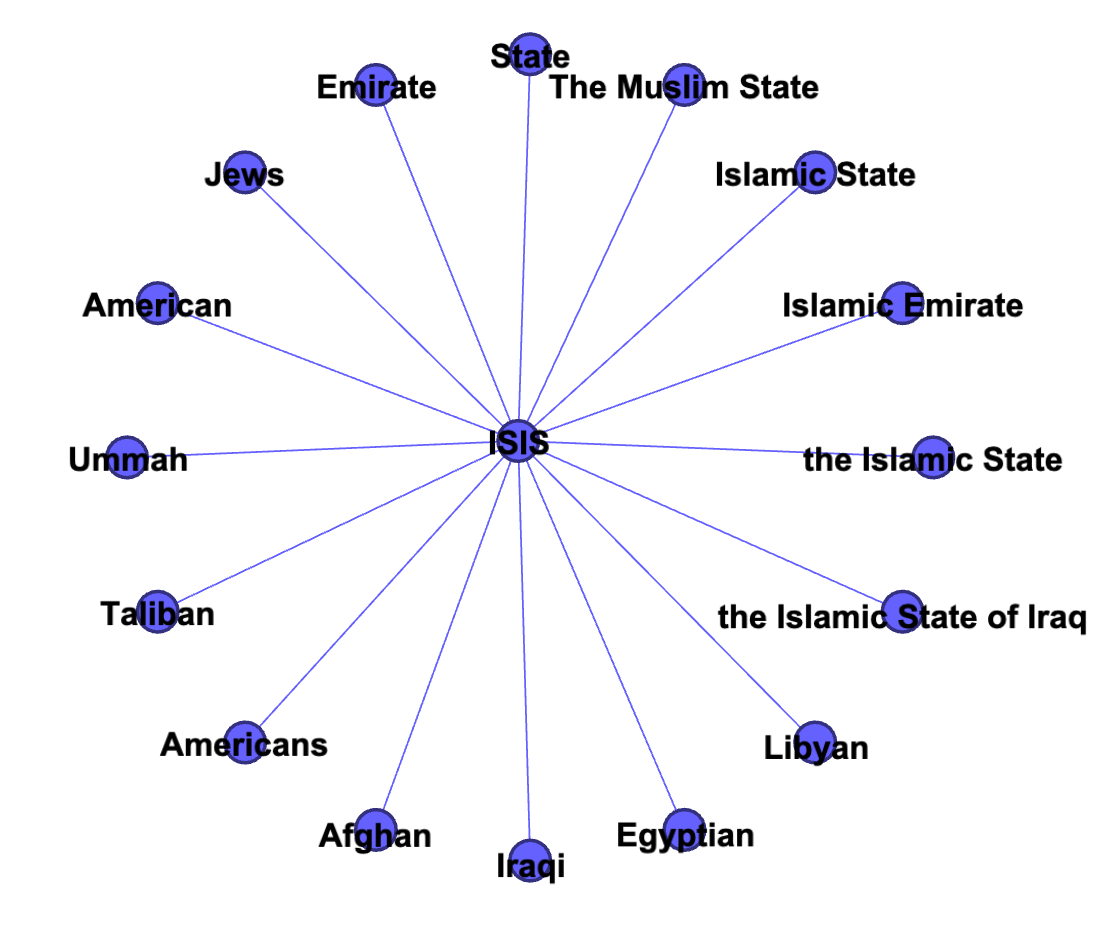

In [4]:
Image(filename= BASEPATH+"AQ about ISIS.png", width = 600, height = 600)

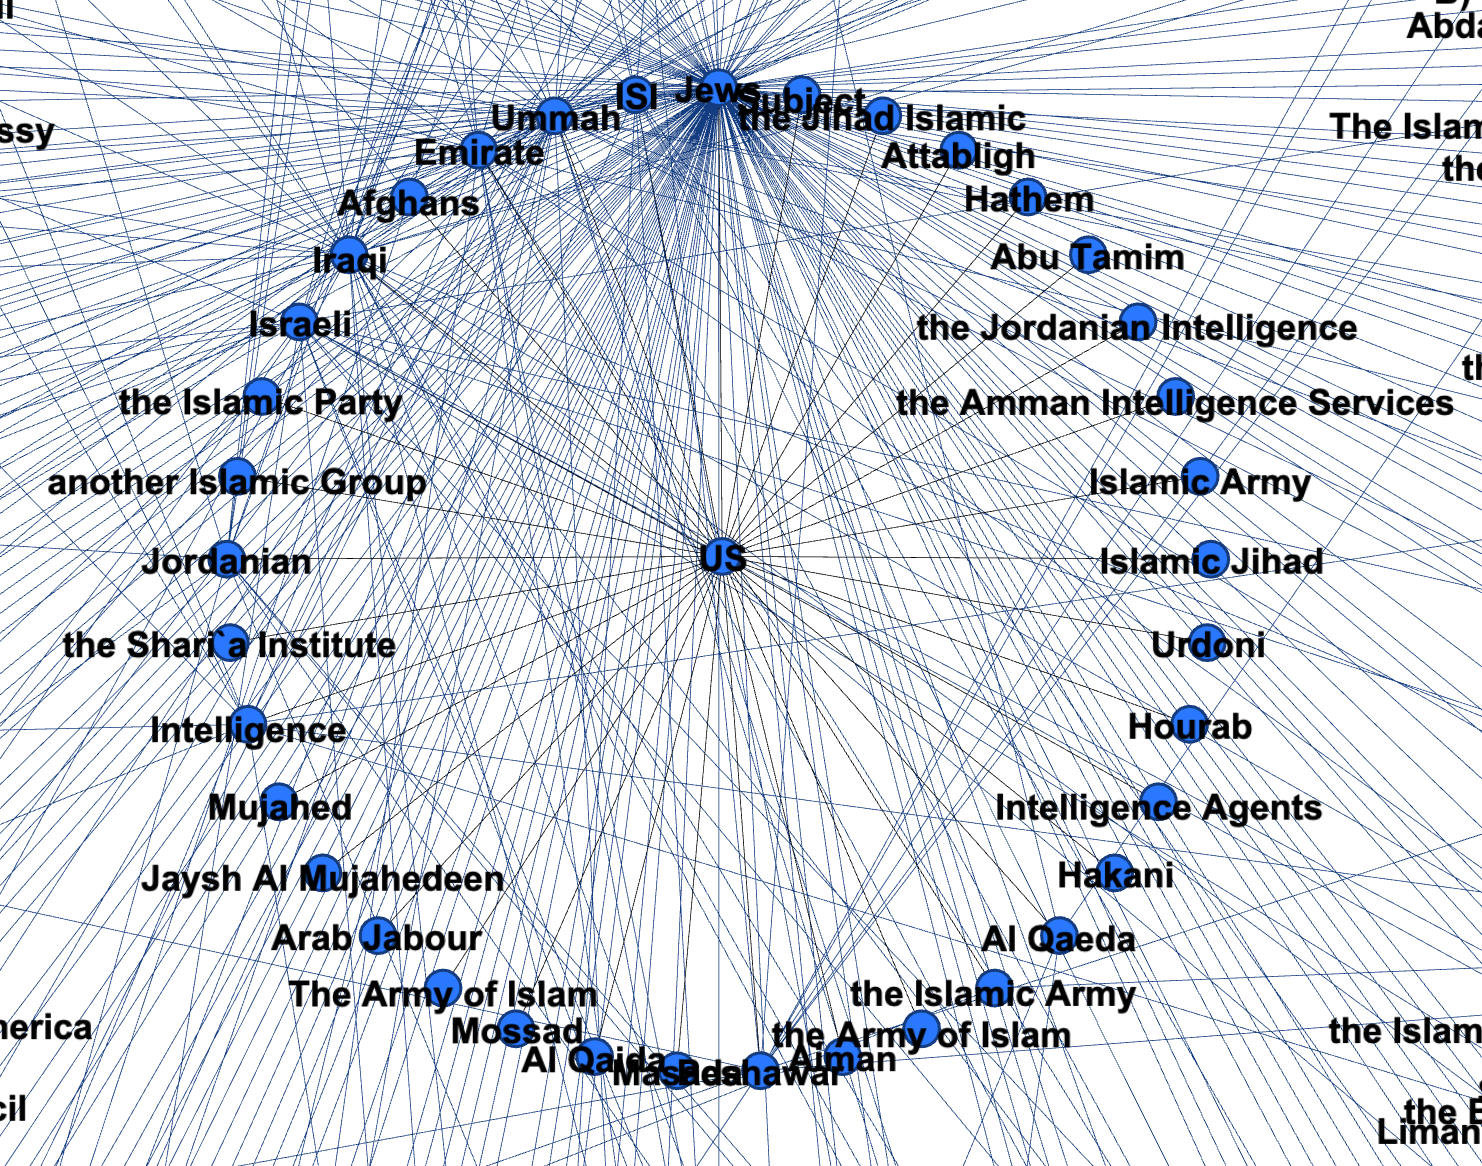

In [10]:
Image(filename= BASEPATH+"AQ about US.png", width = 600, height = 600)

In [121]:
# ENTITY RESOLUTION --> BIG PROBLEM WITH THIS DATA